In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq


In [2]:
class DigitalModulation:
    def __init__(self, bits, sampling_rate=1000, bit_rate=10):
        self.bits = bits
        self.sampling_rate = sampling_rate
        self.bit_rate = bit_rate
        self.samples_per_bit = sampling_rate // bit_rate
        self.t = np.arange(len(bits) * self.samples_per_bit) / sampling_rate
        self.carrier_freq = 100
        self.frequency_deviation = 4 * self.bit_rate

    def add_noise(self, signal_in, snr_db):
        """Add AWGN noise to signal with specified SNR in dB"""
        signal_power = np.mean(signal_in**2)
        noise_power = signal_power / (10**(snr_db/10))
        noise = np.random.normal(0, np.sqrt(noise_power), len(signal_in))
        return signal_in + noise

    def ask_modulation(self):
        """Amplitude Shift Keying"""
        t = self.t
        baseband = np.repeat(self.bits, self.samples_per_bit)
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)
        ask_signal = baseband * carrier
        return ask_signal, baseband

    def fsk_modulation(self):
        """Frequency Shift Keying"""
        t = self.t
        baseband = np.repeat(self.bits, self.samples_per_bit)
        f1 = self.carrier_freq - self.frequency_deviation
        f2 = self.carrier_freq + self.frequency_deviation

        phase = 0
        fsk_signal = np.zeros_like(t)

        for i in range(len(self.bits)):
            start = i * self.samples_per_bit
            end = (i + 1) * self.samples_per_bit
            t_bit = t[start:end] - t[start]

            freq = f2 if self.bits[i] == 1 else f1
            fsk_signal[start:end] = np.cos(2 * np.pi * freq * t_bit + phase)
            phase = 2 * np.pi * freq * t_bit[-1] + phase
            phase = phase % (2 * np.pi)

        return fsk_signal, baseband

    def psk_modulation(self):
        """Phase Shift Keying"""
        t = self.t
        baseband = np.repeat(self.bits, self.samples_per_bit)
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)
        psk_signal = carrier * (2 * baseband - 1)
        return psk_signal, baseband

    def dpsk_modulation(self):
        """Differential Phase Shift Keying"""
        diff_encoded = np.zeros_like(self.bits)
        diff_encoded[0] = self.bits[0]
        for i in range(1, len(self.bits)):
            diff_encoded[i] = diff_encoded[i-1] ^ self.bits[i]

        t = self.t
        baseband = np.repeat(diff_encoded, self.samples_per_bit)
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)
        dpsk_signal = carrier * (2 * baseband - 1)
        return dpsk_signal, baseband

    def ask_demod_coherent(self, received_signal):
        """Coherent ASK demodulation"""
        t = self.t
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)

        # Multiply with carrier
        demod = received_signal * 2 * carrier

        # Low-pass filter
        nyq = self.sampling_rate / 2
        cutoff = self.bit_rate / nyq
        b, a = signal.butter(4, cutoff)
        filtered = signal.filtfilt(b, a, demod)

        # Sample at bit centers
        bit_centers = np.arange(self.samples_per_bit//2, len(filtered), self.samples_per_bit)
        samples = filtered[bit_centers]

        # Decision device
        threshold = 0.5
        decoded_bits = (samples > threshold).astype(int)

        return decoded_bits, filtered

    def ask_demod_noncoherent(self, received_signal):
        """Non-coherent ASK demodulation using envelope detection"""
        # Envelope detection
        envelope = np.abs(signal.hilbert(received_signal))

        # Low-pass filter
        nyq = self.sampling_rate / 2
        cutoff = self.bit_rate / nyq
        b, a = signal.butter(4, cutoff)
        filtered = signal.filtfilt(b, a, envelope)

        # Sample and decide
        bit_centers = np.arange(self.samples_per_bit//2, len(filtered), self.samples_per_bit)
        samples = filtered[bit_centers]
        threshold = np.mean(filtered)
        decoded_bits = (samples > threshold).astype(int)

        return decoded_bits, filtered

    def fsk_demod_coherent(self, received_signal):
        """Coherent FSK demodulation"""
        t = self.t
        f1 = self.carrier_freq - self.frequency_deviation
        f2 = self.carrier_freq + self.frequency_deviation

        # Local carriers
        carrier1 = np.cos(2 * np.pi * f1 * t)
        carrier2 = np.cos(2 * np.pi * f2 * t)

        # Correlate with carriers
        corr1 = received_signal * 2 * carrier1
        corr2 = received_signal * 2 * carrier2

        # Low-pass filter
        nyq = self.sampling_rate / 2
        cutoff = self.bit_rate / nyq
        b, a = signal.butter(4, cutoff)
        filtered1 = signal.filtfilt(b, a, corr1)
        filtered2 = signal.filtfilt(b, a, corr2)

        # Sample and decide
        bit_centers = np.arange(self.samples_per_bit//2, len(filtered1), self.samples_per_bit)
        samples1 = filtered1[bit_centers]
        samples2 = filtered2[bit_centers]
        decoded_bits = (samples2 > samples1).astype(int)

        return decoded_bits, filtered1, filtered2

    def fsk_demod_noncoherent(self, received_signal):
        """Non-coherent FSK demodulation"""
        f1 = self.carrier_freq - self.frequency_deviation
        f2 = self.carrier_freq + self.frequency_deviation

        # Bandpass filters
        nyq = self.sampling_rate / 2
        width = self.bit_rate / nyq
        f1_norm = f1 / nyq
        f2_norm = f2 / nyq

        # Filter for f1
        b1 = signal.firwin(101, [f1_norm-width/2, f1_norm+width/2], pass_zero=False)
        filtered1 = signal.lfilter(b1, 1, received_signal)

        # Filter for f2
        b2 = signal.firwin(101, [f2_norm-width/2, f2_norm+width/2], pass_zero=False)
        filtered2 = signal.lfilter(b2, 1, received_signal)

        # Envelope detection
        envelope1 = np.abs(signal.hilbert(filtered1))
        envelope2 = np.abs(signal.hilbert(filtered2))

        # Sample and decide
        bit_centers = np.arange(self.samples_per_bit//2, len(envelope1), self.samples_per_bit)
        samples1 = envelope1[bit_centers]
        samples2 = envelope2[bit_centers]
        decoded_bits = (samples2 > samples1).astype(int)

        return decoded_bits, envelope1, envelope2

    def psk_demod_coherent(self, received_signal):
        """Coherent PSK demodulation"""
        t = self.t
        carrier = np.cos(2 * np.pi * self.carrier_freq * t)

        # Multiply with carrier
        demod = received_signal * 2 * carrier

        # Low-pass filter
        nyq = self.sampling_rate / 2
        cutoff = self.bit_rate / nyq
        b, a = signal.butter(4, cutoff)
        filtered = signal.filtfilt(b, a, demod)

        # Sample and decide
        bit_centers = np.arange(self.samples_per_bit//2, len(filtered), self.samples_per_bit)
        samples = filtered[bit_centers]
        decoded_bits = (samples > 0).astype(int)

        return decoded_bits, filtered

    def dpsk_demod(self, received_signal):
        """DPSK demodulation"""
        # Delay by one bit
        delayed_signal = np.roll(received_signal, self.samples_per_bit)

        # Multiply with delayed version
        product = received_signal * delayed_signal

        # Low-pass filter
        nyq = self.sampling_rate / 2
        cutoff = self.bit_rate / nyq
        b, a = signal.butter(4, cutoff)
        filtered = signal.filtfilt(b, a, product)

        # Sample and decide
        bit_centers = np.arange(self.samples_per_bit//2, len(filtered), self.samples_per_bit)
        samples = filtered[bit_centers]
        decoded_bits = (samples > 0).astype(int)

        # Differential decode
        diff_decoded = np.zeros_like(decoded_bits)
        diff_decoded[0] = decoded_bits[0]
        for i in range(1, len(decoded_bits)):
            diff_decoded[i] = diff_decoded[i-1] ^ decoded_bits[i]

        return diff_decoded, filtered

def plot_demodulation(original_bits, received_signal, demodulated_signal, decoded_bits, mod_type, demod_type):
    """Plot demodulation results"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

    # Plot received signal
    ax1.plot(received_signal[:500], label='Received')
    ax1.set_title(f'{mod_type} - {demod_type} Demodulation - Received Signal')
    ax1.grid(True)
    ax1.legend()

    # Plot demodulated signal
    ax2.plot(demodulated_signal[:500], label='Demodulated')
    ax2.set_title('Demodulated Signal')
    ax2.grid(True)
    ax2.legend()

    # Plot bit comparison
    ax3.stem(original_bits[:20], label='Original', linefmt='b-', markerfmt='bo')
    ax3.stem(decoded_bits[:20], label='Decoded', linefmt='r--', markerfmt='rx')
    ax3.set_title('Bit Comparison')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    return fig




Bit Error Rates at  10 SNR:
ASK Coherent: 0.000
ASK Non-coherent: 0.000
FSK Coherent: 0.480
FSK Non-coherent: 0.210
PSK Coherent: 0.000
DPSK: 0.510


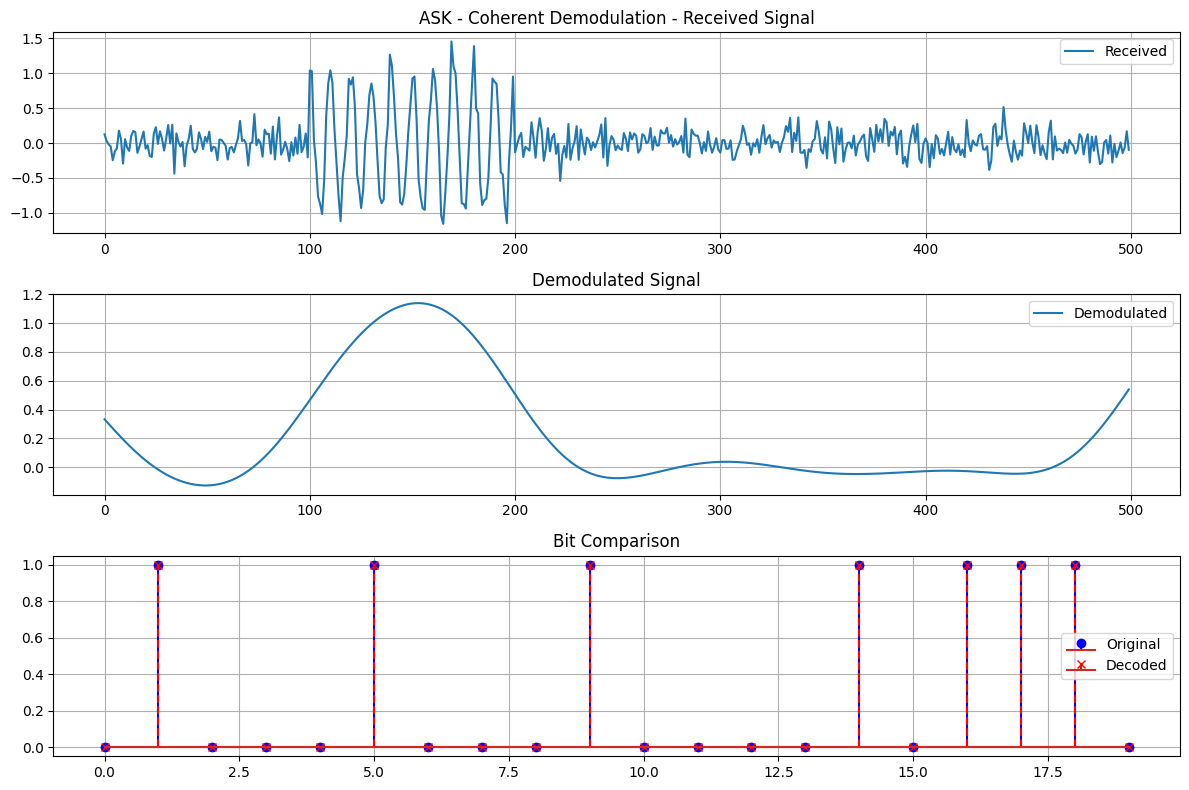

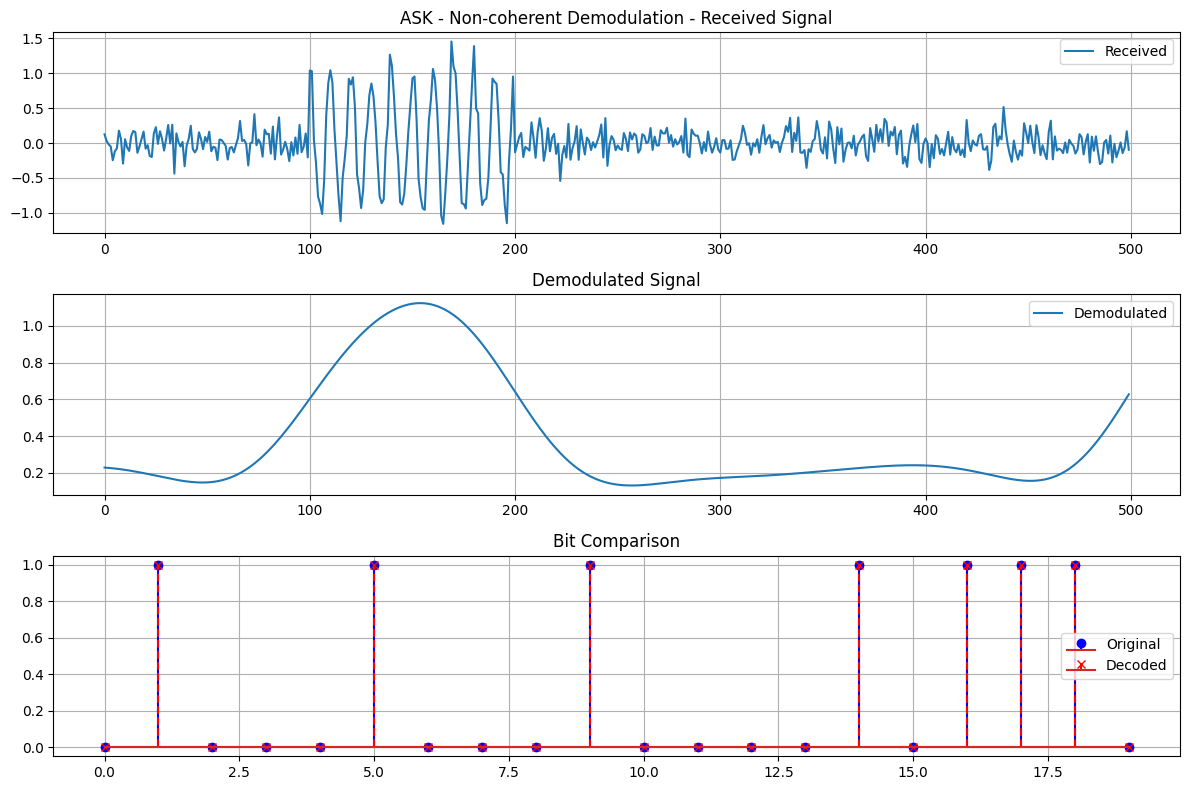

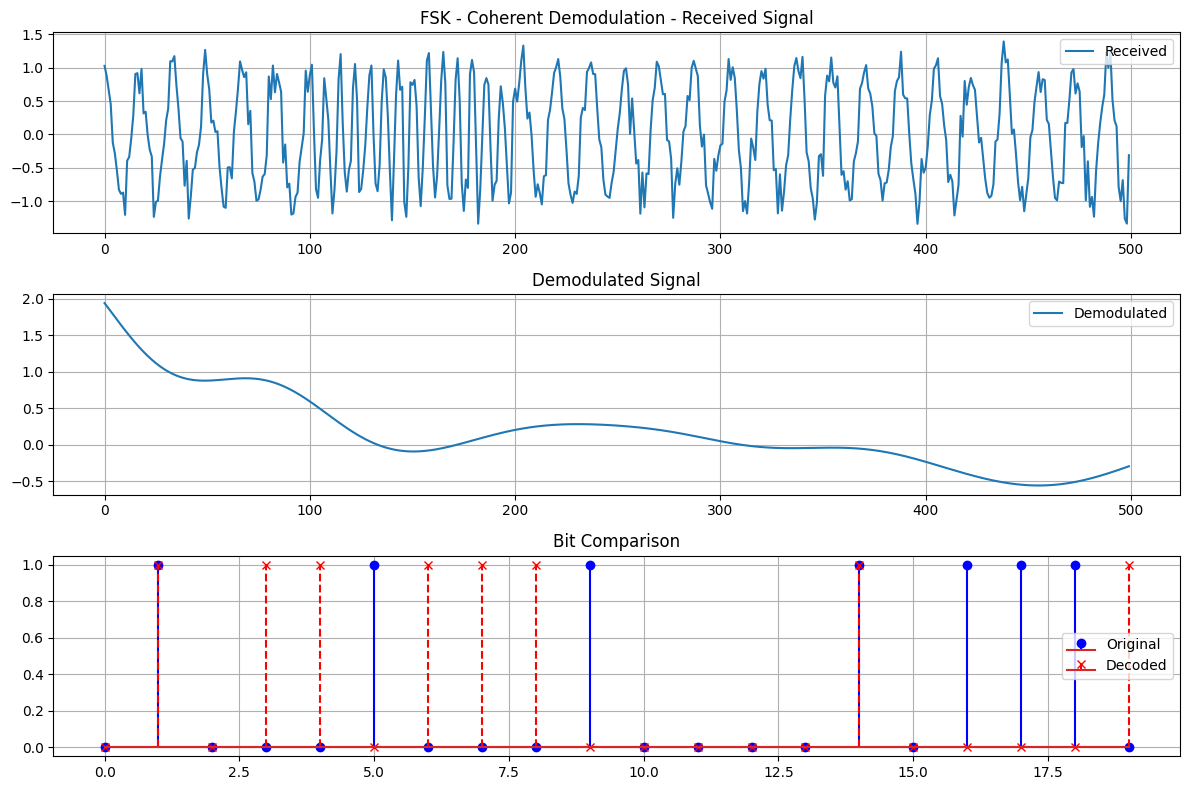

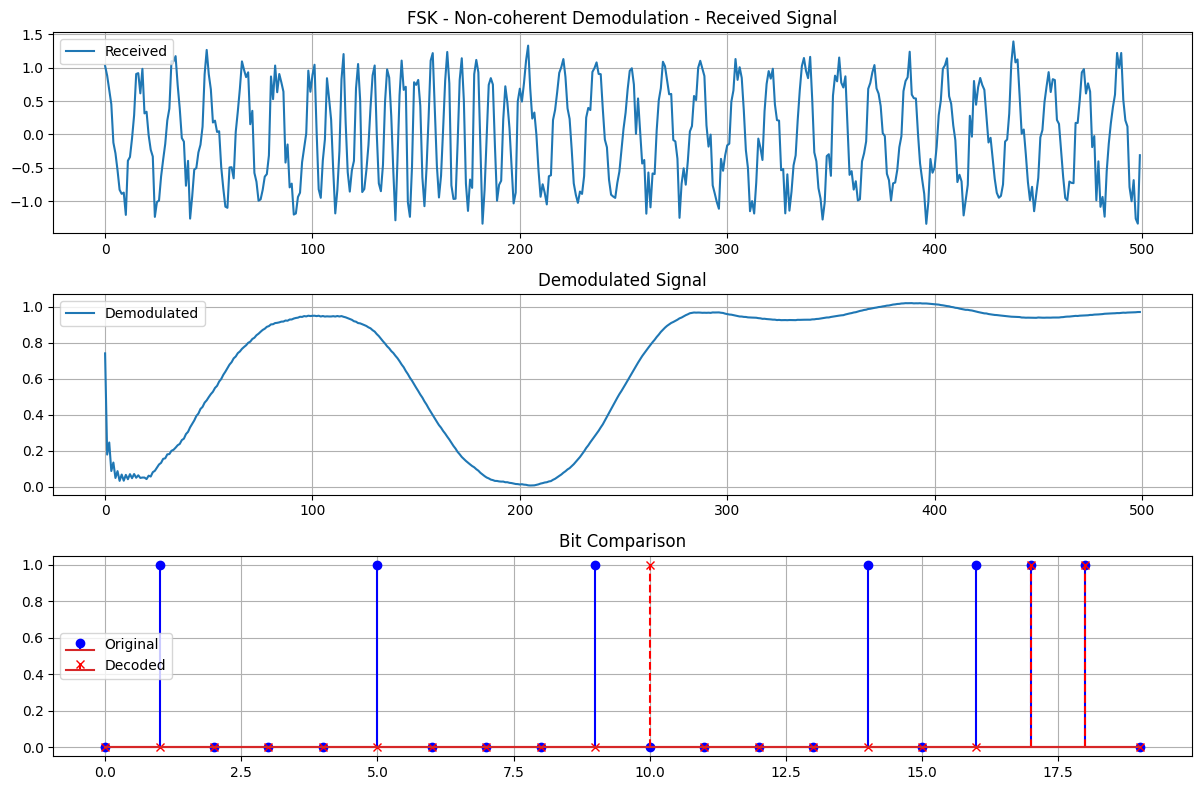

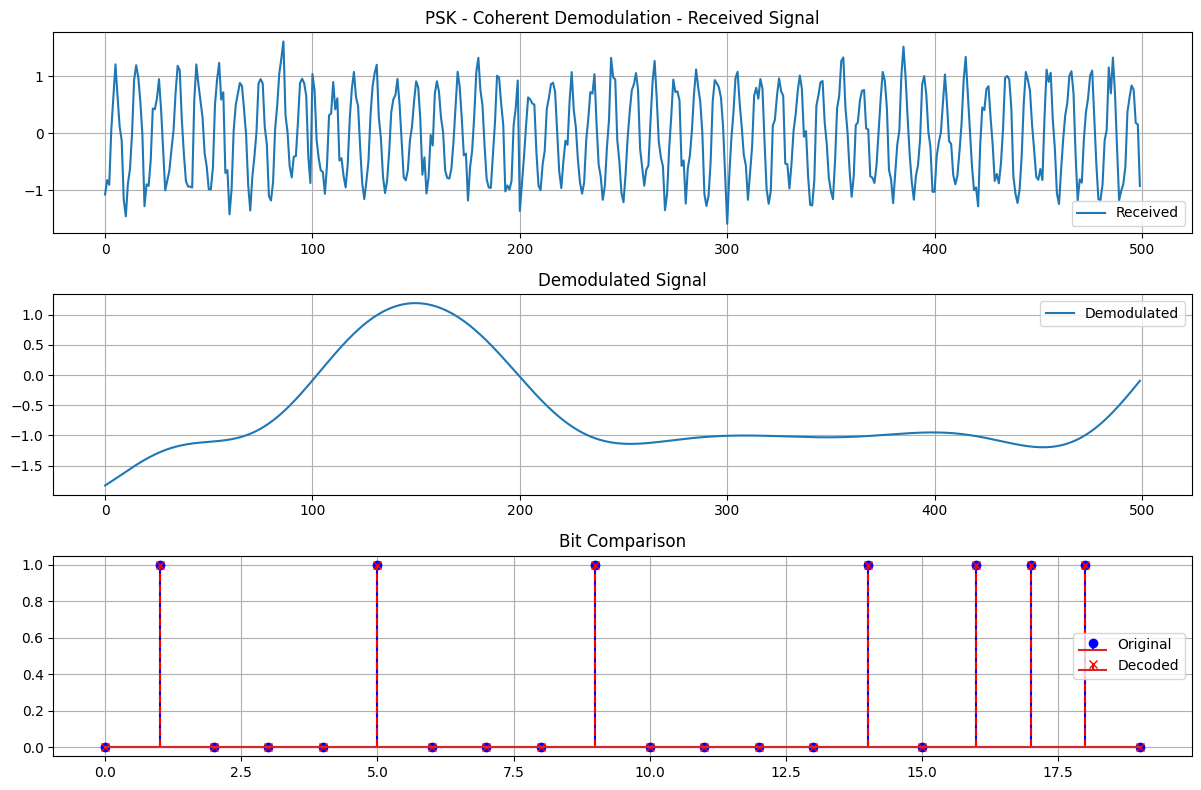

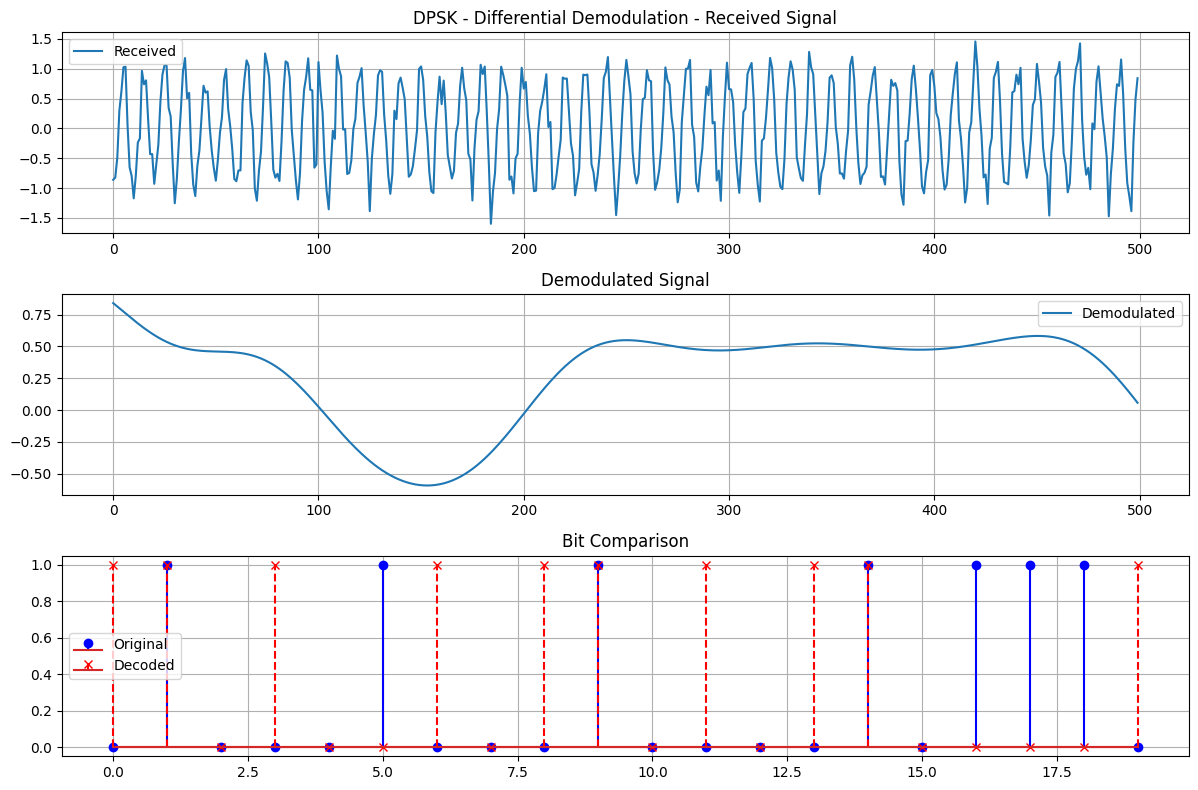

In [4]:
if __name__ == "__main__":
    # Generate random bits
    np.random.seed(42)
    bits = np.random.randint(0, 2, 100)
    SNR=10

    # Create modulation object
    mod = DigitalModulation(bits)

    # Test ASK
    ask_signal, ask_baseband = mod.ask_modulation()
    noisy_ask = mod.add_noise(ask_signal, SNR)  # 10dB SNR

    # Coherent ASK demodulation
    decoded_ask_coh, demod_ask_coh = mod.ask_demod_coherent(noisy_ask)
    plot_demodulation(bits, noisy_ask, demod_ask_coh, decoded_ask_coh, 'ASK', 'Coherent')

    # Non-coherent ASK demodulation
    decoded_ask_nc, demod_ask_nc = mod.ask_demod_noncoherent(noisy_ask)
    plot_demodulation(bits, noisy_ask, demod_ask_nc, decoded_ask_nc, 'ASK', 'Non-coherent')

    # Test FSK
    fsk_signal, fsk_baseband = mod.fsk_modulation()
    noisy_fsk = mod.add_noise(fsk_signal, SNR)

    # Coherent FSK demodulation
    decoded_fsk_coh, demod_fsk_coh1, demod_fsk_coh2 = mod.fsk_demod_coherent(noisy_fsk)
    plot_demodulation(bits, noisy_fsk, demod_fsk_coh1, decoded_fsk_coh, 'FSK', 'Coherent')

    # Non-coherent FSK demodulation
    decoded_fsk_nc, demod_fsk_nc1, demod_fsk_nc2 = mod.fsk_demod_noncoherent(noisy_fsk)
    plot_demodulation(bits, noisy_fsk, demod_fsk_nc1, decoded_fsk_nc, 'FSK', 'Non-coherent')

    # Test PSK
    psk_signal, psk_baseband = mod.psk_modulation()
    noisy_psk = mod.add_noise(psk_signal, SNR)
    decoded_psk, demod_psk = mod.psk_demod_coherent(noisy_psk)
    plot_demodulation(bits, noisy_psk, demod_psk, decoded_psk, 'PSK', 'Coherent')

    # Test DPSK
    dpsk_signal, dpsk_baseband = mod.dpsk_modulation()
    noisy_dpsk = mod.add_noise(dpsk_signal, SNR)
    decoded_dpsk, demod_dpsk = mod.dpsk_demod(noisy_dpsk)
    plot_demodulation(bits, noisy_dpsk, demod_dpsk, decoded_dpsk, 'DPSK', 'Differential')

    # Print BER
    print("\nBit Error Rates at ", SNR, "SNR:")
    print(f"ASK Coherent: {np.mean(bits != decoded_ask_coh):.3f}")
    print(f"ASK Non-coherent: {np.mean(bits != decoded_ask_nc):.3f}")
    print(f"FSK Coherent: {np.mean(bits != decoded_fsk_coh):.3f}")
    print(f"FSK Non-coherent: {np.mean(bits != decoded_fsk_nc):.3f}")
    print(f"PSK Coherent: {np.mean(bits != decoded_psk):.3f}")
    print(f"DPSK: {np.mean(bits != decoded_dpsk):.3f}")

    plt.show()
